<a href="https://colab.research.google.com/github/pgreisen/PEVAE_Paper/blob/master/TrR_sco_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TrRosetta for single-sequence

# load libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import string
import os.path
import os
from sklearn.metrics import pairwise_distances

In [0]:
%tensorflow_version 2.x

# Should work in both TF1 and TF2
import tensorflow as tf
import tensorflow.compat.v1 as tf1
import tensorflow.compat.v1.keras.backend as K1
tf1.disable_eager_execution()

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, Dense, Lambda, Layer, Concatenate
import tensorflow.keras.backend as K

## Define model

In [0]:
def TrRosetta():
  '''returns TrRosetta model'''
  class PSSM(Layer):
    # note, here we replace the MRF layer with a PSSM layer
    def __init__(self):
      super(PSSM, self).__init__()  
    def call(self, inputs):
      N,L,A = [tf.shape(inputs)[k] for k in range(3)]
      x = inputs
      with tf.name_scope('1d_features'):
        f1d_seq = x[:,:,:20]
        h_i = tf.ones((N,L,1))
        feat_1D = tf.concat([f1d_seq, x, h_i], axis=-1)
        feat_1D_tile_A = tf.tile(feat_1D[:,:,None,:], [1,1,L,1])
        feat_1D_tile_B = tf.tile(feat_1D[:,None,:,:], [1,L,1,1])
      feat = tf.concat([feat_1D_tile_A,feat_1D_tile_B],axis=-1)
      return tf.reshape(feat, [-1,L,L,42*2])

  class instance_norm(Layer):
    def __init__(self, axes=(1,2)):
      super(instance_norm, self).__init__()
      self.axes = axes
    def build(self, input_shape):
      self.beta  = self.add_weight(name='beta',shape=(input_shape[-1],),
                                  initializer='zeros',trainable=True)
      self.gamma = self.add_weight(name='gamma',shape=(input_shape[-1],),
                                  initializer='ones',trainable=True)
    def call(self, inputs):
      mean, variance = tf.nn.moments(inputs, self.axes, keepdims=True)
      return tf.nn.batch_normalization(inputs, mean, variance, self.beta, self.gamma, 1e-6)

  inputs = Input((None,21))
  B = PSSM()(inputs)
  B = Dense(64)(B)
  B = instance_norm()(B)
  A = Activation("elu")(B)

  # Resnet
  dilation = 1
  for _ in range(5*12 + 1):
    B = Conv2D(64, 3, dilation_rate=dilation, padding='SAME')(A)
    B = instance_norm()(B)
    B = Activation("elu")(B)
    # B = Dropout(0.15)(B)
    B = Conv2D(64, 3, dilation_rate=dilation, padding='SAME')(B)
    B = instance_norm()(B)
    A = Activation("elu")(A+B)
    
    dilation *= 2
    if dilation > 16: dilation = 1

  # Predictions
  A_asym    = A
  p_theta   = Dense(25, activation="softmax")(A_asym)
  p_phi     = Dense(13, activation="softmax")(A_asym)

  A_sym     = Lambda(lambda x: (x + tf.transpose(x,[0,2,1,3]))/2)(A)
  p_cb_dist = Dense(37, activation="softmax")(A_sym)
  p_bb      = Dense(3,  activation="softmax")(A_sym)
  p_omega   = Dense(25, activation="softmax")(A_sym)
  
  # Model
  model_tmp = Model(inputs, [p_theta, p_phi, p_cb_dist, p_bb, p_omega])
  outs = Concatenate()([p_theta, p_phi, p_cb_dist, p_omega])
  model = Model(inputs, outs)

  return model_tmp, model

# Load weights
Note there are 5 seperate models (xaa, xab, xac, xad, xae) trained for TrRosetta

In [0]:
%%bash
wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/models.zip
unzip -qqo models.zip

In [0]:
!pwd

/content


In [0]:
def set_weights(model, token):
  file = f"models/model_{token}.npy"
  weights = [np.squeeze(w) for w in np.load(file, allow_pickle=True)]
  weights[0] = weights[0][:84]
  model.set_weights(weights)

def model_predict(x, batch_size=None):
  y = [m.predict(x, batch_size=batch_size) for m in models]
  return np.stack(y,0)

# load all models into memory
K.clear_session()
models = []

# note if you get memory error, you can try loading a subset of the models
# for example, weights = ["xaa","xab"]
weights = ["xaa","xab","xac","xad","xae"]

for weight in weights:
  model_tmp, model = TrRosetta()
  set_weights(model_tmp, weight)
  models.append(model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# PARSE FUNCTIONS

In [0]:
alpha_1 = list("ARNDCQEGHILKMFPSTWYV-")
states = len(alpha_1)
alpha_3 = ['ALA','ARG','ASN','ASP','CYS','GLN','GLU','GLY','HIS','ILE', 
           'LEU','LYS','MET','PHE','PRO','SER','THR','TRP','TYR','VAL','GAP']
aa_1_N = {a:n for n,a in enumerate(alpha_1)}
aa_N_1 = {n:a for n,a in enumerate(alpha_1)}
aa_1_3 = {a:b for a,b in zip(alpha_1,alpha_3)}
aa_3_1 = {b:a for a,b in zip(alpha_1,alpha_3)}

aa_comp = np.array([0.07892653, 0.04979037, 0.0451488 , 0.0603382 , 0.01261332,
                    0.03783883, 0.06592534, 0.07122109, 0.02324815, 0.05647807,
                    0.09311339, 0.05980368, 0.02072943, 0.04145316, 0.04631926,
                    0.06123779, 0.0547427 , 0.01489194, 0.03705282, 0.0691271])
aa_comp /= aa_comp.sum()

def N_to_AA(x,d=1):
  if d == 2:
    return ["".join([aa_N_1.get(a,"-") for a in y]) for y in x]
  else:
    return "".join([aa_N_1.get(a,"-") for a in x])

def parse_PDB(x, atoms=['N','CA','C']):
  '''
  input:  x = PDB filename
          atoms = atoms to extract (optional)
  output: (length, atoms, coords=(x,y,z)), sequence
  '''
  n,seq,xyz = {},[],{}
  for atom in atoms:
    n[atom],xyz[atom] = 0,[]
  for line in open(x,"r"):
    line = line.rstrip()
    if line[:4] == "ATOM":
      atom = line[12:12+4].strip()
      resi = line[17:17+3]
      resn = int(line[22:22+5])-1
      x = float(line[30:30+8])
      y = float(line[38:38+8])
      z = float(line[46:46+8])

      # extract sequence
      while len(seq) < resn: seq.append("GAP")
      if len(seq) == resn: seq.append(resi)
      elif seq[-1] == "GAP": seq[-1] = resi

      # extract coordiantes
      if atom in atoms:
        while n[atom] < resn:
          xyz[atom].append([np.nan,np.nan,np.nan])
          n[atom] += 1
        if n[atom] == resn:
          xyz[atom].append([x,y,z])
          n[atom] += 1

  # add missing atoms
  for atom in atoms:
    while n[atom] < len(seq):
      xyz[atom].append([np.nan,np.nan,np.nan])
      n[atom] += 1

  seq = np.array([aa_1_N.get(aa_3_1.get(aa, "-"), states-1) for aa in seq])
  xyz = np.stack(([xyz[atom] for atom in atoms]),axis=1)
  return xyz, np.eye(21)[seq]

def extend(a,b,c, L,A,D):
  '''
  input:  3 coords (a,b,c), (L)ength, (A)ngle, and (D)ihedral
  output: 4th coord
  '''
  N = lambda x: x/np.sqrt(np.square(x).sum(-1,keepdims=True))
  bc = N(b-c)
  n = N(np.cross(b-a, bc))
  m = [bc,np.cross(n,bc),n]
  d = [L*np.cos(A), L*np.sin(A)*np.cos(D), -L*np.sin(A)*np.sin(D)]
  return c + sum([m*d for m,d in zip(m,d)])
  
def to_len(a,b):
  '''given coordinates a-b, return length or distance'''
  return np.sqrt(np.sum(np.square(a-b),axis=-1))

def to_ang(a,b,c):
  '''given coordinates a-b-c, return angle'''
  D = lambda x,y: np.sum(x*y,axis=-1)
  N = lambda x: x/np.sqrt(np.square(x).sum(-1,keepdims=True) + 1e-8)
  return np.arccos(D(N(b-a),N(b-c)))

def to_dih(a,b,c,d):
  '''given coordinates a-b-c-d, return dihedral'''
  D = lambda x,y: np.sum(x*y,axis=-1)
  N = lambda x: x/np.sqrt(np.square(x).sum(-1,keepdims=True) + 1e-8)
  bc = N(b-c)
  n1 = np.cross(N(a-b),bc)
  n2 = np.cross(bc,N(c-d))
  return np.arctan2(D(np.cross(n1,bc),n2),D(n1,n2))

def prep_input(pdb):
  '''Parse PDB file and return features compatible with TrRosetta'''
  ncac, seq = parse_PDB(pdb,["N","CA","C"])

  # mask gap regions
  mask = seq.argmax(-1) != 20
  ncac, seq = ncac[mask], seq[mask]

  N,CA,C = ncac[:,0], ncac[:,1], ncac[:,2]
  CB = extend(C, N, CA, 1.522, 1.927, -2.143)

  cb_ref    = to_len(CB[:,None], CB[None,:])
  omega_ref = to_dih(CA[:,None], CB[:,None], CB[None,:], CA[None,:])
  theta_ref = to_dih( N[:,None], CA[:,None], CB[:,None], CB[None,:])
  phi_ref   = to_ang(CA[:,None], CB[:,None], CB[None,:])

  def mtx2bins(x_ref, start, end, nbins, mask):
    bins = np.linspace(start, end, nbins)
    x_true = np.digitize(x_ref, bins).astype(np.uint8)
    x_true[mask] = 0
    return np.eye(nbins)[x_true]

  p_cb    = mtx2bins(cb_ref,       2.0,  20.0, 37, mask=(cb_ref > 20))
  p_omega = mtx2bins(omega_ref, -np.pi, np.pi, 25, mask=(p_cb[...,0]==1))
  p_theta = mtx2bins(theta_ref, -np.pi, np.pi, 25, mask=(p_cb[...,0]==1))
  p_phi   = mtx2bins(phi_ref,      0.0, np.pi, 13, mask=(p_cb[...,0]==1))

  true    = np.concatenate([p_theta, p_phi, p_cb, p_omega],-1)
  return {"seq":seq, "true":true}

# score function
For each PDB we report:
*   CCE  - agreement between ALL features   [lower better]
*   ACC  - agreement between CB<8A features [higher better]

In [0]:
def get_cce_acc(seq, true, batch_size=100):
  '''compute aggreement between predicted distributions'''
  def CCE(pred, true, eps=1e-8):
    cce = (true * np.log(pred+eps)).sum(-1)/(true.sum(-1)+eps)
    return -(cce).mean((-1,-2))

  def ACC(pred, true, sep=5, bce=False, eps=1e-8):
    # bins ranges: theta[0:25]phi[25:38]cb[38:75]omega[75:100]
    # p(cb < 8) range: [38:75][1:13] = [39:51]
    # sum CB-CB prediction to compute: Prob(CB < 8)
    pred = pred[...,39:51].sum(-1) # (model, batch, len, len)
    true = true[...,39:51].sum(-1)

    i,j = np.triu_indices(pred.shape[-1],k=sep)
    P,T = pred[...,i,j],true[...,i,j]

    pos = (T*P).sum(-1)/(T.sum(-1)+eps)
    neg = ((1-T)*(1-P)).sum(-1)/((1-T).sum(-1)+eps)
    sco =  2.0*(pos*neg)/(pos+neg+eps)      
    return sco

  pred = model_predict(seq, batch_size)

  
  # score with mean output
  pred_mean = pred.mean(0)
  cce = CCE(pred_mean,true)
  acc = ACC(pred_mean,true)
  return {"pred": pred_mean, "scores":{"cce": cce, "acc": acc}}

#analysis code

In [0]:
def analyze_one(pdb=None, seq_replace=None, feat=None):
  '''given pdb file, parse, return true/pred and scores'''
  if feat is None: feat = prep_input(pdb)
  seq = feat["seq"] if seq_replace is None else seq_replace
  sco = get_cce_acc(seq[None], feat["true"])
  pred = np.squeeze(sco["pred"])
  scores = {k:float(np.squeeze(sc)) for k,sc in sco["scores"].items()}

  return {"seq":seq, "true":feat["true"],
          "pred":pred, "scores":scores}

def plot_one(feat):
  cb_true = feat["true"][...,38:75].argmax(-1)
  cb_pred = feat["pred"][...,38:75].argmax(-1)
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1); plt.title("true"); plt.imshow(cb_true)
  plt.subplot(1,2,2); plt.title("pred"); plt.imshow(cb_pred)
  plt.show()

# POSITIVE CONTROL
Denovo designs by baker lab!

What Ivan A. found is that TrRosetta does very good on Denovo designs from baker-lab. Assuming your designs are on the same "level" it should also think its good.

**WARNING**
- Does NOT work for repeat proteins. Turns out the way tr-rosetta knows the difference between local (diagonal) and non-local (non-diagonal), is if i==j... for repeat protein i==(j+offset)... and it cannot distinguish this from i==j.

In [0]:
%%bash
wget -qnc https://files.ipd.uw.edu/krypton/pos_control.zip
unzip -oqq pos_control.zip

{'cce': 1.514181238601445, 'acc': 0.767061918139066}


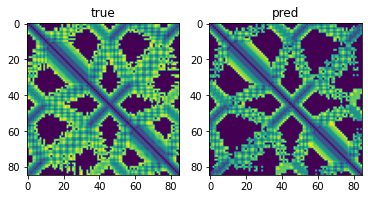

In [0]:
feat = analyze_one("pos_control/6NUK.pdb")
print(feat["scores"])
plot_one(feat)

In [0]:
feat.keys()

dict_keys(['seq', 'true', 'pred', 'scores'])

In [0]:
# mutate first position to A
feat["seq"][0] = np.eye(21)[aa_1_N["A"]]

{'cce': 1.5137033169339376, 'acc': 0.7650566900784384}


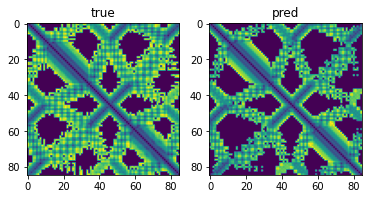

In [0]:
feat = analyze_one(feat=feat)
print(feat["scores"])
plot_one(feat)

In [0]:
# mutate all to random
for i in range(len(feat["seq"])):
  feat["seq"][i] = np.eye(21)[np.random.randint(20)]

{'cce': 2.6704403399036845, 'acc': 0.05987920768213418}


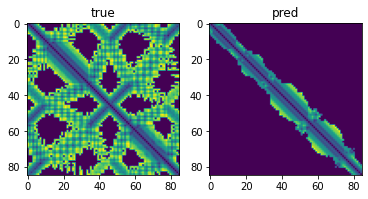

In [0]:
feat = analyze_one(feat=feat)
print(feat["scores"])
plot_one(feat)